# Ковидын эерэг болон сөрөг 2 ангилалын загвар

## Сангуудаа импортлох

In [13]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, LeakyReLU, BatchNormalization, MaxPooling1D, Dropout

## Өгөгдлөө унших

In [5]:
dataset = pd.read_csv('../../input/augmented_data/spectrum.csv', low_memory=False)

In [6]:
display(dataset.head().T, dataset.shape)

,0,1,2,3,4
320,23.767617,6.554332,-65.876227,-3.539452,-32.211329
321,8.541673,-3.982771,-52.107447,-25.36141,3.569451
322,-6.737708,-12.508809,-43.797257,-22.890028,-25.360113
323,-13.844851,-14.161707,-34.973131,-15.633461,-24.382165
324,-15.338898,-11.528857,-24.758405,-24.196508,-13.837212
...,...,...,...,...,...
classfication,0,0,0,0,0
negpos,0,0,0,0,0
medium,NaN,NaN,NaN,NaN,NaN
mediumclassification,NaN,NaN,NaN,NaN,NaN


(6400, 1338)

## Өгөгдлөө бэлдэх

In [7]:
def preprocess_data(data):
    labels = data.columns[-7:]
    X = data.drop(labels, axis=1)
    X.columns = X.columns.astype(int)
    y = data['covid_status']

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    return X_train, X_test, y_train_encoded, y_test_encoded

In [8]:
X_train, X_test, y_train, y_test = preprocess_data(dataset)

In [9]:
_ , counts = np.unique(y_train, return_counts=True)
print('Train set: ', counts)
_ , counts = np.unique(y_test, return_counts=True)
print('Test set: ', counts)

Train set:  [ 975 3825]
Test set:  [ 325 1275]


In [10]:
NUM_EPOCHS = 50

In [11]:
def simple_cnn(X_train, X_test, y_train, y_test, num_epochs=NUM_EPOCHS):

    model = Sequential([
        Conv1D(16, 21, input_shape=(X_train.shape[1], 1)),
        BatchNormalization(),
        LeakyReLU(0.01),
        MaxPooling1D(16),
        Dropout(0.1),

        Conv1D(32, 11),
        BatchNormalization(),
        LeakyReLU(0.01),
        MaxPooling1D(8),
        Dropout(0.1),

        Conv1D(64, 5),
        BatchNormalization(),
        LeakyReLU(0.01),
        MaxPooling1D(4),
        
        Flatten(),
        BatchNormalization(),

        Dense(2048, activation='tanh'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []
    for i in range(num_epochs):
        history = model.fit(X_train, y_train, epochs=1, batch_size=8, verbose=0)
        
        train_loss.append(history.history['loss'][0])
        train_accuracy.append(history.history['accuracy'][0])

        loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

        test_loss.append(loss)
        test_accuracy.append(accuracy)
        if (i + 1) % 5 == 0:
            print(f'Epoch {i+1} => Test Loss: {loss:.2f} - Test Accuracy: {accuracy*100:.2f}%')

    plt.figure(figsize=(15, 8))
    # plt.plot(train_loss, label='train_loss')
    plt.plot(train_accuracy, label='train_accuracy')
    # plt.plot(test_loss, label='test_loss')
    plt.plot(test_accuracy, label='test_accuracy')
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    # plt.ylim(0, 1)
    plt.legend(loc='upper left')
    plt.show()

    return model

Epoch 5 => Test Loss: 0.00 - Test Accuracy: 100.00%
Epoch 10 => Test Loss: 0.00 - Test Accuracy: 100.00%
Epoch 15 => Test Loss: 0.00 - Test Accuracy: 100.00%
Epoch 20 => Test Loss: 0.00 - Test Accuracy: 100.00%
Epoch 25 => Test Loss: 0.00 - Test Accuracy: 100.00%
Epoch 30 => Test Loss: 0.00 - Test Accuracy: 100.00%
Epoch 35 => Test Loss: 0.00 - Test Accuracy: 100.00%
Epoch 40 => Test Loss: 0.00 - Test Accuracy: 100.00%
Epoch 45 => Test Loss: 0.00 - Test Accuracy: 100.00%
Epoch 50 => Test Loss: 0.00 - Test Accuracy: 100.00%


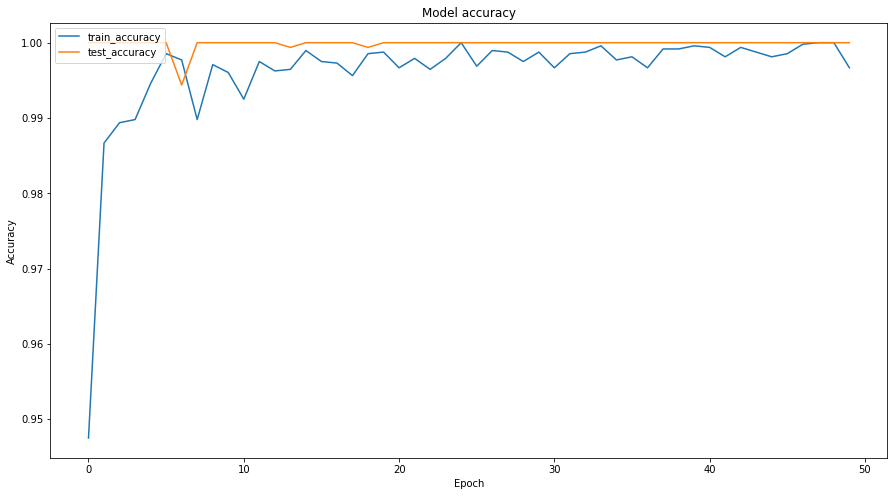

In [12]:
lenet_model = simple_cnn(X_train, X_test, y_train, y_test)

50/50 [==============================] - 0s 3ms/step


,0,1,2,3,4,5,6,7,8,9,...,1590,1591,1592,1593,1594,1595,1596,1597,1598,1599
0,1,0,0,1,0,1,0,1,1,1,...,1,1,1,1,1,0,0,1,1,1


,0,1,2,3,4,5,6,7,8,9,...,1590,1591,1592,1593,1594,1595,1596,1597,1598,1599
0,1,0,0,1,0,1,0,1,1,1,...,1,1,1,1,1,0,0,1,1,1


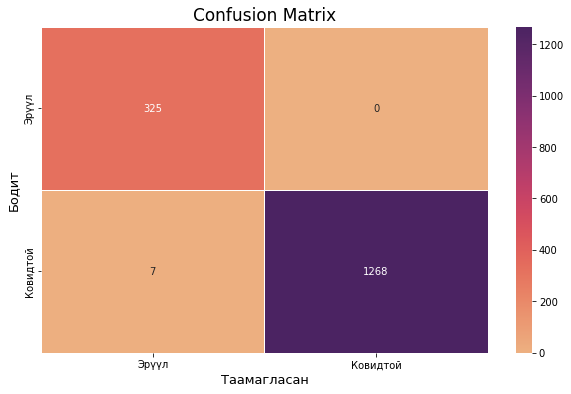

In [14]:
y_pred = lenet_model.predict(X_test)
y_pred = y_pred.astype(int).reshape(-1)
display(pd.DataFrame(y_test).T, pd.DataFrame(y_pred).T)

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10, 6)) 
sns.heatmap(cm, 
            ax=ax,
            annot=True,
            cmap="flare",
            linewidth=.5,
            fmt='g', 
            xticklabels=['Эрүүл','Ковидтой'],
            yticklabels=['Эрүүл','Ковидтой'])
plt.xlabel('Таамагласан',fontsize=13)
plt.ylabel('Бодит',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [15]:
tp, fn, fp, tn = cm.ravel()
print(f"TP: {tp} FN: {fn} \nFP: {fp} TN: {tn}")

report = classification_report(y_test, y_pred)

sensitivity_ = tp / (tp + fn)
specificity = tn / (tn + fp)
accuracy = (tp + tn) / (tp + fp + tn + fn)

print(f"Sensitivity: {100 * sensitivity_:.2f}%")
print(f"Specificity: {100 * specificity:.2f}%")
print(f"Accuracy: {100 * accuracy:.2f}%")
print("Classification Report:\n", report)

TP: 325 FN: 0 
FP: 7 TN: 1268
Sensitivity: 100.00%
Specificity: 99.45%
Accuracy: 99.56%
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       325
           1       1.00      0.99      1.00      1275

    accuracy                           1.00      1600
   macro avg       0.99      1.00      0.99      1600
weighted avg       1.00      1.00      1.00      1600



In [16]:
test_ds = pd.read_csv('../../input/clinical_sample/spectrum.csv')

In [17]:
test_ds.shape

(35, 1333)

In [18]:
display(test_ds.head().T)

,0,1,2,3,4
320,25.2983,20.30437,16.893959,-36.049651,-11.886235
321,31.479134,-3.791936,16.638892,-19.645126,-12.665922
322,35.972784,-22.084277,16.978177,-2.667237,-11.410453
323,42.426246,-23.550407,22.367232,9.265691,4.168963
324,50.000132,-10.324397,30.121312,16.180717,29.627829
...,...,...,...,...,...
1648,5.494818,1.140878,1.415732,-4.302907,-20.411472
1649,-5.673703,7.089428,2.36151,1.27773,-26.535186
1650,-11.573432,9.249651,-11.636861,-8.427642,-27.951783
covid_status,positive,positive,positive,positive,positive


In [19]:
_X_test = test_ds.drop(['covid_status', 'description'], axis=1)
_X_test.columns = _X_test.columns.astype(int)
_y_test = np.ones(_X_test.shape[0]).astype(int)

2/2 [==============================] - 0s 2ms/step

CNN Model:
Accuracy: 74.29%
Confusion Matrix:
 [[ 0  0]
 [ 9 26]]


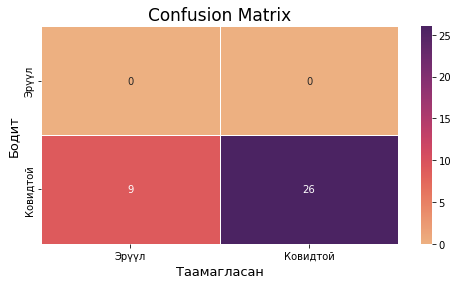

In [24]:
_y_pred = lenet_model.predict(_X_test)
_y_pred = _y_pred.astype(int).reshape(-1)
accuracy = accuracy_score(_y_test, _y_pred)
# report = classification_report(_y_test, _y_pred)
cm = confusion_matrix(_y_test, _y_pred)

print(f"\nCNN Model:")
print(f"Accuracy: {100*accuracy:.2f}%")
# print("Classification Report:\n", report)
print("Confusion Matrix:\n", cm)

fig, ax = plt.subplots(figsize=(8, 4)) 
sns.heatmap(cm, 
            ax=ax,
            annot=True,
            cmap="flare",
            linewidth=.5,
            fmt='g', 
            xticklabels=['Эрүүл','Ковидтой'],
            yticklabels=['Эрүүл','Ковидтой'])
plt.xlabel('Таамагласан',fontsize=13)
plt.ylabel('Бодит',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()